In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('cardio_train.csv', sep=';', index_col=0)
data.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


# Pre-Processing

In [3]:
df = data.copy()

In [4]:
#df = df[['age','weight','height', 'ap_hi', 'cardio']]
#df = df.drop('alco',axis = 1)

# TrainTest - Nettoyage - Encodage

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
trainset, testset = train_test_split(df, test_size=0.2, random_state=42)

In [7]:
trainset['cardio'].value_counts()

0    28033
1    27967
Name: cardio, dtype: int64

In [8]:
testset['cardio'].value_counts()

1    7012
0    6988
Name: cardio, dtype: int64

In [9]:
def encodage(df):
    df = pd.get_dummies(df, columns=['gender', 'cholesterol'], drop_first=True)
    return df

In [10]:
(df.isna().sum()/df.shape[0]).sort_values(ascending=True)

age            0.0
gender         0.0
height         0.0
weight         0.0
ap_hi          0.0
ap_lo          0.0
cholesterol    0.0
gluc           0.0
smoke          0.0
alco           0.0
active         0.0
cardio         0.0
dtype: float64

#### Pas besoin de traiter les valeurs NaN

In [11]:
def preprocessing(df):
    df = encodage(df)

    X = df.drop('cardio', axis = 1)
    y = df['cardio']

    print(y.value_counts())
    return X, y

In [12]:
X_train, y_train = preprocessing(trainset)

0    28033
1    27967
Name: cardio, dtype: int64


In [13]:
X_test, y_test = preprocessing(testset)

1    7012
0    6988
Name: cardio, dtype: int64


# Evaluation

In [20]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve

In [21]:
def evaluation(model):
    
    model.fit(X_train, y_train)
    ypred = model.predict(X_test)
    
    print(confusion_matrix(y_test, ypred))
    print(classification_report(y_test, ypred))  

    N, train_score, val_score = learning_curve(model, X_train, y_train,
                                              cv=4, scoring='f1',
                                               train_sizes=np.linspace(0.1, 1, 10))
    
    
    plt.figure(figsize=(12, 8))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.legend()

# Modelisation

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

In [15]:
#model_1 = DecisionTreeClassifier(random_state=42)

In [16]:
#model_2 = RandomForestClassifier(random_state=42)

In [17]:
#model_3 = make_pipeline(SelectKBest(f_classif, k = 8), model_2)

In [18]:
#model_4 = make_pipeline(PolynomialFeatures(2), SelectKBest(f_classif, k=10),RandomForestClassifier(random_state=0))

#### Les paramêtres obtenant les meilleurs résultats dans le Pre - Processing ont été sélectionnés.

In [19]:
RandomForest = RandomForestClassifier(random_state=0)
AdaBoost = AdaBoostClassifier(random_state=42)
SVM = make_pipeline(StandardScaler(), SVC(random_state=42))
KNN = make_pipeline(StandardScaler(), KNeighborsClassifier())

In [22]:
dict_of_models = {'RandomForest': RandomForest,
                  'AdaBoost' : AdaBoost,
                  'SVM': SVM,
                  'KNN': KNN
                 }

RandomForest
[[5076 1912]
 [2105 4907]]
              precision    recall  f1-score   support

           0       0.71      0.73      0.72      6988
           1       0.72      0.70      0.71      7012

    accuracy                           0.71     14000
   macro avg       0.71      0.71      0.71     14000
weighted avg       0.71      0.71      0.71     14000

AdaBoost
[[5584 1404]
 [2296 4716]]
              precision    recall  f1-score   support

           0       0.71      0.80      0.75      6988
           1       0.77      0.67      0.72      7012

    accuracy                           0.74     14000
   macro avg       0.74      0.74      0.73     14000
weighted avg       0.74      0.74      0.73     14000

SVM
[[5340 1648]
 [2122 4890]]
              precision    recall  f1-score   support

           0       0.72      0.76      0.74      6988
           1       0.75      0.70      0.72      7012

    accuracy                           0.73     14000
   macro avg       0.

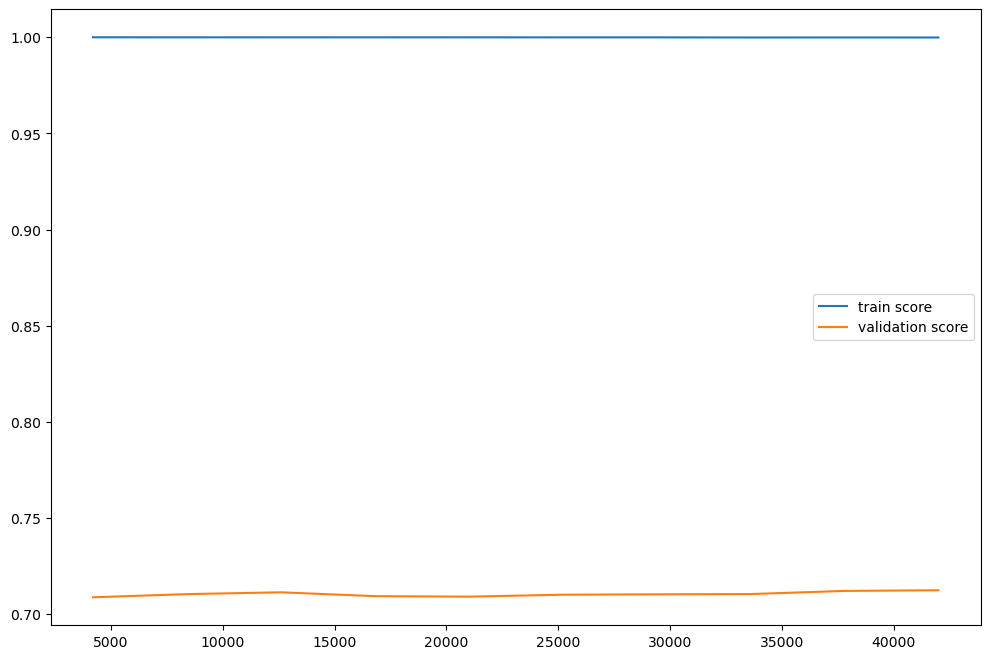

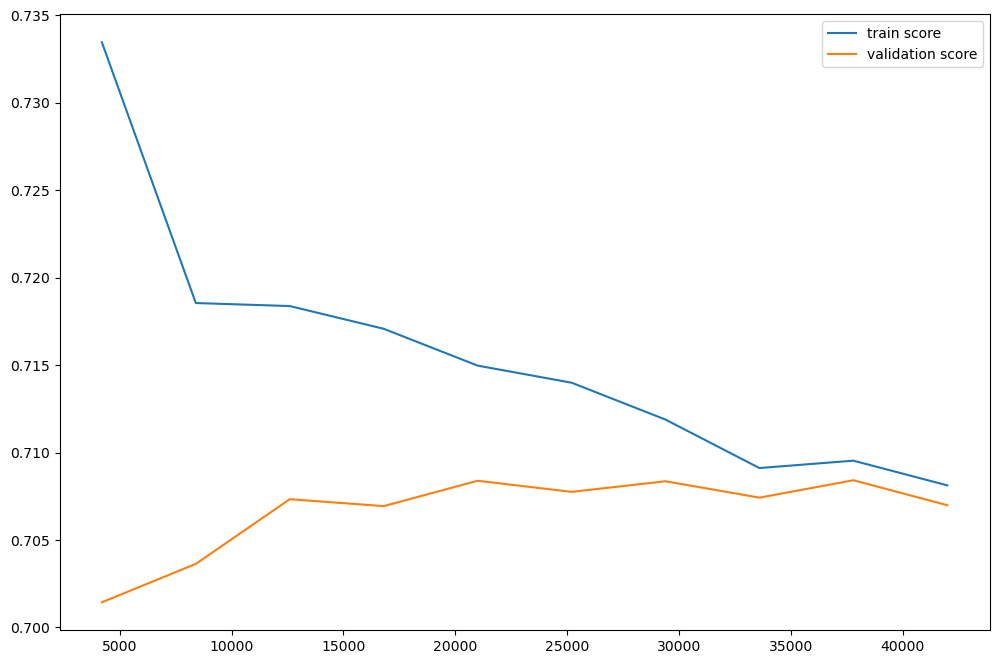

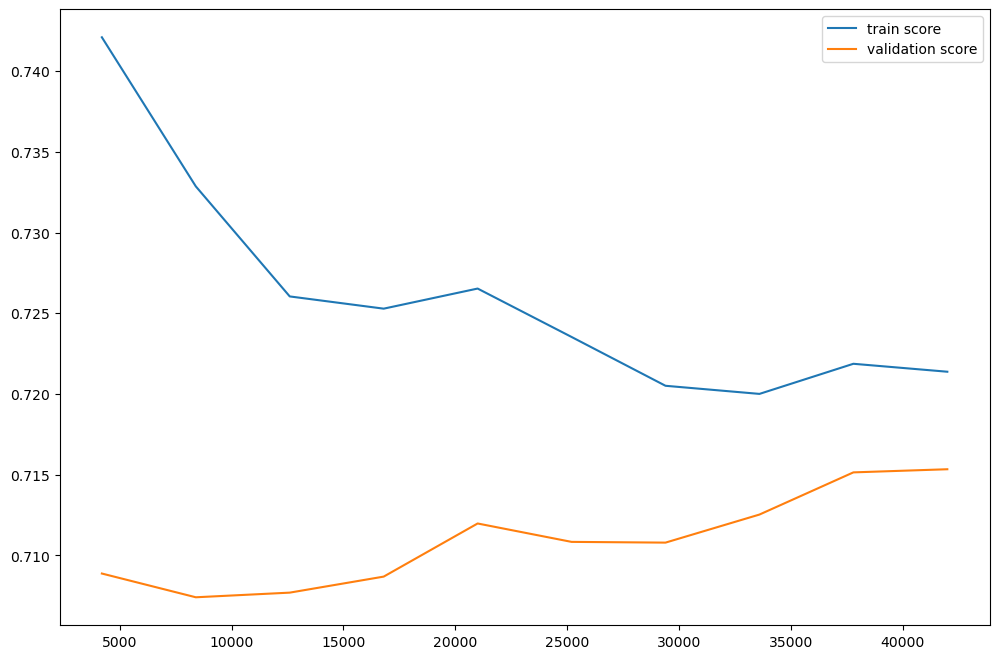

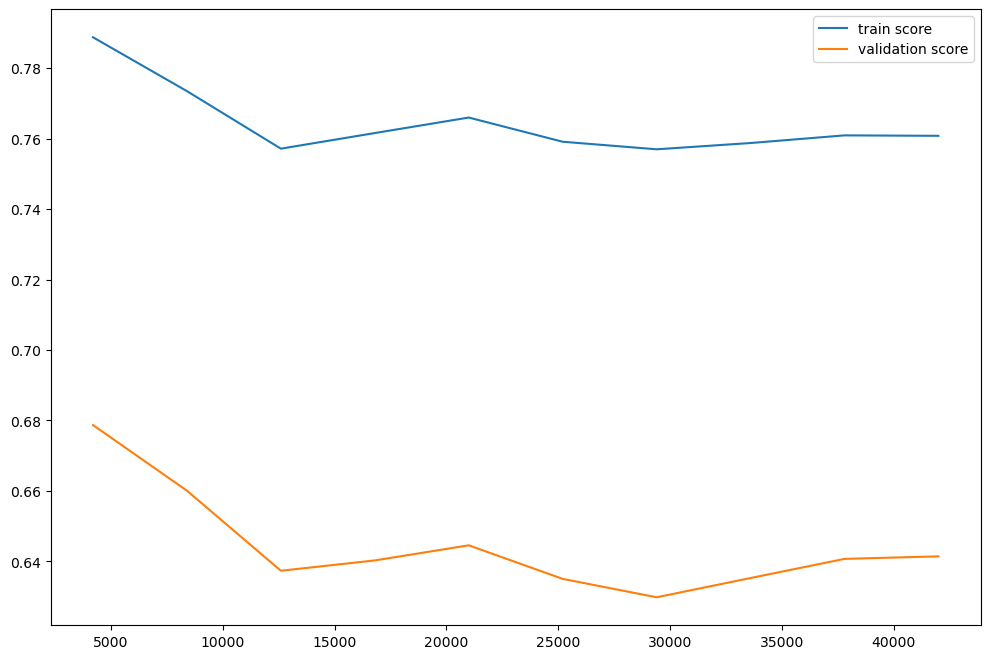

In [23]:
for name, model in dict_of_models.items():
    print(name)
    evaluation(model)

### Je vais me concentrer sur SVM qui a la meilleure combinaison F score et recall pour détecter les défaillances cardiaques. De plus, les courbes nous apprennent qu'il n'est pas en overfitting.

# OPTIMISATION

In [24]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [25]:
SVM

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(random_state=42))])

In [26]:
hyper_params = {'svc__gamma':[1e-3, 1e-4],
                'svc__C':[1, 10, 100, 1000]}

In [28]:
grid = GridSearchCV(SVM, hyper_params, scoring='recall', cv=4)
# recall parce que je considère qu'il ne faut surtout pas placer des 1 de cardio dans la catégorie 0 : ne pas détecter les futures défaillances cardiaques
grid.fit(X_train, y_train)

print(grid.best_params_)

y_pred = grid.predict(X_test)

print(classification_report(y_test, y_pred))

{'svc__C': 1000, 'svc__gamma': 0.001}
              precision    recall  f1-score   support

           0       0.71      0.80      0.75      6988
           1       0.77      0.67      0.72      7012

    accuracy                           0.73     14000
   macro avg       0.74      0.73      0.73     14000
weighted avg       0.74      0.73      0.73     14000



#### La performance s'est dégradée. Je pourrais continuer à chercher à l'améliorer en utilisant un dictionnaires d'hyperparamêtres avec des plages de données très grandes et en utilisant plusieurs RandomizedSearchCV en réduisant au fur et à mesures les plages de données.

#### Dans le cas de cet exercice, je ne vais pas le faire car les calculs prennent trop de temps sur mon laptop et vais donc garder le modèle SVM de base.

# Precision Recall Curve

In [29]:
from sklearn.metrics import precision_recall_curve

In [33]:
precision, recall, threshold = precision_recall_curve(y_test, SVM.decision_function(X_test))

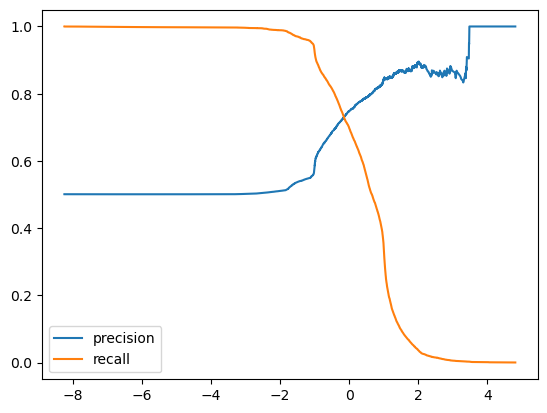

In [34]:
plt.plot(threshold, precision[:-1], label='precision')
plt.plot(threshold, recall[:-1], label='recall')
plt.legend()

In [35]:
def model_final(model, X, threshold):
    return model.decision_function(X) > threshold

In [40]:
y_pred = model_final(SVM, X_test, threshold=-1)

In [37]:
from sklearn.metrics import recall_score

In [41]:
f1_score(y_test, y_pred)

0.7163453571231289

In [42]:
recall_score(y_test, y_pred)

0.9247005134055905

#### En sélectionnant un treshold de 0 j'obtenais un f1 score de 0.72 mais un recall de 0.69. Nous travaillons sur les défaillances cardiaques donc je donne la préférence au treshold.